# fastgraph.pagegraph

> David's stuff!

In [ ]:
# default_exp pagegraph
# default_cls_lvl 3

In [ ]:
#export
from functools import singledispatch
from torch import nn

In [ ]:
#hide
from nbdev.showdoc import *

## Drawing graphs

In [ ]:
#export
def split(path, sep = '/'):
    i = path.rfind(sep) + 1
    return path[:i].rstrip(sep), path[i:]

In [ ]:
#export
def make_dot_graph(nodes, edges, direction='LR', **kwargs):
    from pydot import Dot, Cluster, Node, Edge
    class Subgraphs(dict):
        def __missing__(self, path):
            parent, label = split(path)
            subgraph = Cluster(path, label=label, style='rounded, filled', fillcolor='#77777744')
            self[parent].add_subgraph(subgraph)
            return subgraph
    g = Dot(rankdir=direction, directed=True, **kwargs)
    g.set_node_defaults(
        shape='box', style='rounded, filled', fillcolor='#ffffff')
    subgraphs = Subgraphs({'': g})
    for path, attr in nodes:
        parent, label = split(path)
        subgraphs[parent].add_node(
            Node(name=path, label=label, **attr))
    for src, dst, attr in edges:
        g.add_edge(Edge(src, dst, **attr))
    return g

In [ ]:
#export
def to_dict(inputs):
    return dict(enumerate(inputs)) if isinstance(inputs, list) else inputs

In [ ]:
#export
class DotGraph():
    def __init__(self, graph, size=None, direction='LR'):
        self.nodes = [(k, v) for k, (v,_) in graph.items()]
        self.edges = [(src, dst, {'tooltip': name}) for dst, (_, inputs) in graph.items() for name, src in to_dict(inputs).items()]
        self.size, self.direction = size or 8+len(graph)/3, direction

    def dot_graph(self, **kwargs):
        return make_dot_graph(self.nodes, self.edges, size=self.size, direction=self.direction,  **kwargs)

    def svg(self, **kwargs):
        return self.dot_graph(**kwargs).create(format='svg').decode('utf-8')
    try:
        import pydot
        _repr_svg_ = svg
    except ImportError:
        def __repr__(self): return 'pydot is needed for network visualisation'

Let's define a compact way of representing directed graphs (suitable for describing neural networks) as python dictionaries. Each node has a *name* which should be a string, a *value* which can be anything and an (ordered) list of *inputs* representing incoming edges from other nodes. Inputs are ordered as they typically represent function args. We can alternatively provide a dict of *inputs* to represent named args. Here is our graph format:


```
Graph := {name: (value, [input])}
```

or

```
Graph := {name: (value, {input_name: input}}
```

Here is an example of such a Graph using both kinds of inputs:


In [ ]:
#define some node values - just strings for now we'll use more interesting values later
A,B,C,D = 'Aa Bb Cc Dd'.split()

graph = {
    'a': (A, []),
    'b': (B, ['a']),
    'c': (C, {'x': 'a', 'y': 'c'}),
    'd': (D, ['b'])
}

It will be useful to be able to display Graphs. Here is a function that does that:

In [ ]:
#export
def draw_graph(graph):
    return DotGraph({name: ({'tooltip': str(value)}, inputs) for name, (value,inputs) in graph.items()}, size=10)

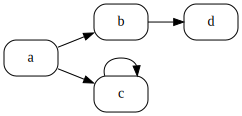

In [ ]:
draw_graph(graph)

## Exploding graphs

In [ ]:
#export
def iter_nodes(graph):
    # graph = {name: node for (name, node) in graph.items() if node is not None}
    keys = list(graph.keys())
    if not all(isinstance(k, str) for k in keys):
        raise Exception('Node names must be strings.')
    return ((name, (node if isinstance(node, tuple) else (node, [0 if j is 0 else keys[j-1]])))
            for (j, (name, node)) in enumerate(graph.items()))

In [ ]:
#export
map_ = lambda func, vals: [func(x) for x in vals] if isinstance(vals, list) else {k: func(v) for k,v in vals.items()}
pfx = lambda prefix, name: f'{prefix}/{name}'
external_inputs = lambda graph: set(i for name, (value, inputs) in iter_nodes(graph) for i in inputs if i not in graph)

In [ ]:
#export
def bindings(graph, inputs):
    if isinstance(inputs, list): inputs = dict(enumerate(inputs))
    required_inputs = external_inputs(graph)
    missing = [k for k in required_inputs if k not in inputs]
    if len(missing): 
        raise Exception(f'Required inputs {missing} are missing from inputs {inputs} for graph {graph}')
    return inputs

In [ ]:
#export
walk = lambda dct, key: walk(dct, dct[key]) if key in dct else key

In [ ]:
#export
_all_ = ['to_graph']

In [ ]:
#export
@singledispatch
def to_graph(value): 
    raise NotImplementedError(f'type = {type(value)}')

In [ ]:
#export
@to_graph.register(dict)
def _(x): return x

In [ ]:
#export
def maybe_graph(x):
    try: return to_graph(x)
    except NotImplementedError: return x

In [ ]:
#export
def explode(graph, max_levels=-1, convert=maybe_graph):
    graph = convert(graph)
    if max_levels==0 or not isinstance(graph, dict): return graph
    redirects = {}
    def iter_(graph):
        for name, (value, inputs) in iter_nodes(graph):
            value = explode(value, max_levels-1, convert=convert)
            if isinstance(value, dict):
                #special case empty dict
                if not len(value): 
                    if len(inputs) != 1: raise Exception('Empty graphs (pass-thrus) should have exactly one input')
                    redirects[name] = inputs[0] #redirect to input
                else:
                    bindings_dict = bindings(value, inputs)
                    for n, (val, ins) in iter_nodes(value):
                        yield (pfx(name, n), (val, map_((lambda i: bindings_dict.get(i, pfx(name, i))), ins)))
                    redirects[name] = pfx(name, n) #redirect to previous node
            else:
                yield (name, (value, inputs))
    return {name: (value, map_((lambda i: walk(redirects, i)), inputs)) for name, (value, inputs) in iter_(graph)}

## Creating Networks

In [ ]:
#export
class ColorMap(dict):
    palette = ['#'+x for x in (
        'bebada,ffffb3,fb8072,8dd3c7,80b1d3,fdb462,b3de69,fccde5,bc80bd,ccebc5,ffed6f,1f78b4,33a02c,e31a1c,ff7f00,'
        '4dddf8,e66493,b07b87,4e90e3,dea05e,d0c281,f0e189,e9e8b1,e0eb71,bbd2a4,6ed641,57eb9c,3ca4d4,92d5e7,b15928'
    ).split(',')]

    def __missing__(self, key):
        self[key] = self.palette[len(self) % len(self.palette)]
        return self[key]

    def _repr_html_(self):
        css = (
        '.pill {'
            'margin:2px; border-width:1px; border-radius:9px; border-style:solid;'
            'display:inline-block; width:100px; height:15px; line-height:15px;'
        '}'
        '.pill_text {'
            'width:90%; margin:auto; font-size:9px; text-align:center; overflow:hidden;'
        '}'
        )
        s = '<div class=pill style="background-color:{}"><div class=pill_text>{}</div></div>'
        return '<style>'+css+'</style>'+''.join((s.format(color, text) for text, color in self.items()))

In [ ]:
#export
class Network(nn.Module):
    colors = ColorMap()
    def __init__(self, graph, cache_activations=False):
        self._graph = to_graph(graph)
        super().__init__()
        self.cache_activations = cache_activations
        for path, (val, _) in iter_nodes(self._graph):  setattr(self, path.replace('/', '__'), val)
    
    def __setattr__(self, name, value):
        super().__setattr__(name, value)
        path = name.replace('__', '/')
        if path in self._graph:
            old_val = self._graph[path]
            self._graph[path] = (value, old_val[1]) if isinstance(old_val, tuple) else value

    def forward(self, *args):
        prev = args[0]
        outputs = self.cache = dict(enumerate(args))
        for k, (node, inputs) in iter_nodes(self._graph):
            if k not in outputs:prev = outputs[k] = node(*[outputs[x] for x in inputs])
        if not self.cache_activations: self.cache = None
        return prev

    def draw(self, **kwargs):
        return DotGraph({p: ({'fillcolor': self.colors[type(v).__name__], 'tooltip': str(v)}, inputs)
                         for p, (v, inputs) in iter_nodes(to_graph(self))}, **kwargs)

    def explode(self, max_levels=-1):
        convert = lambda x: to_graph(x) if isinstance(x, Network) else x
        return Network(explode(self, max_levels, convert=convert))

In [ ]:
#export
def to_network(module, max_levels=-1):
    net = Network(module)
    if max_levels == 0: return net
    for k, mod in net.named_children():
        try: setattr(net, k, to_network(mod, max_levels-1))
        except NotImplementedError: pass
    return net

In [ ]:
#export
@to_graph.register(Network)
def _(x): return x._graph    

## Export -

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
